# Response functions
This notebook provides an overview of the response functions that are available in Pastas. Response functions describe the response of the dependent variable (e.g., groundwater levels) to an independent variable (e.g., groundwater pumping) and form a fundamental part in the transfer function noise models implemented in Pastas. Depending on the problem under investigation, a less or more complex response function may be required, where the complexity is quantified by the number of parameters. Response function are generally used in combination with a stressmodel, but in this notebook the response functions are studied independently to provide an overview of the different response functions and what they represent.

In [7]:
import numpy as np
import pandas as pd
import pastas as ps

import matplotlib.pyplot as plt

ps.show_versions()

Python version: 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
Numpy version: 1.20.3
Scipy version: 1.7.1
Pandas version: 1.3.4
Pastas version: 0.19.0b
Matplotlib version: 3.4.2


## The use of response functions
Depending on the stress type (e.g., recharge, river levels or groundwater pumping) different response function may be used. All response functions that are tested and supported in Pastas are summarized in the table below for reference. The equation in the third column is the formula for the impulse response function ($\theta(t)$).

|Name|Parameters|Formula|Description|
|----|----------|:------|-----------|
| FourParam |4 - A, n, a, b| $$ \theta(t) = A \frac{t^{n-1}}{a^n \Gamma(n)} e^{-t/a- ab/t} $$ | Response function with four parameters that may be used for many purposes. Many other response function are a simplification of this function. |
| Gamma |3 - A, a, n | $$ \theta(t) = A \frac{t^{n-1}}{a^n \Gamma(n)} e^{-t/a} $$ | Three parameter version of FourParam, used for all sorts of stresses ($b=0$) |
| Exponential |2 - A, a | $$ \theta(t) = \frac{A}{a} e^{-t/a} $$ | Response function that can be used for stresses that have an (almost) instant effect. ($n=1$ and $b=0$)|
| Hantush |3 - A, a, b | $$ \theta(t) = At^{-1} e^{-t/a - ab/t} $$ | Response function commonly used for groundwater abstraction wells ($n=0$) |
| Polder |3 - a, b, c | $$ \theta(t) = At^{-3/2} e^{-t/a -b/t} $$ | Response function commonly used to simulate the effects of (river) water levels on the groundwater levels ($n=-1/2$) |
| DoubleExponential |4 - A, $\alpha$, $a_1$,$a_2$| $$ \theta(t) = A (1 - \alpha) e^{-t/a_1} + A \alpha e^{-t/a_2} $$ | Response Function with a double exponential, simulating a fast and slow response. |
| Edelman | 1 - $\beta$ | $$ \theta(t) = \text{?} $$ | The function of Edelman, describing the propagation of an instantaneous water level change into an adjacent half-infinite aquifer. | 
| HantushWellModel | 3 - A, a, b| $$ \theta(t) = \text{?} $$ | A special implementation of the Hantush well function for multiple wells. |

Below the different response functions are plotted.

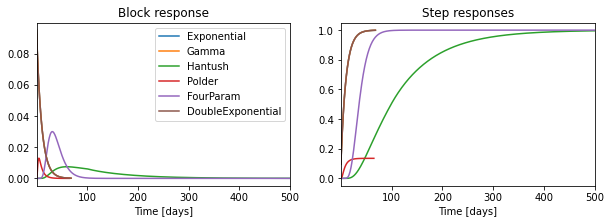

In [8]:
# Default Settings
cutoff = 0.999
meanstress = 1
up = True

responses = {}
exp = ps.Exponential(up=up, meanstress=meanstress, cutoff=cutoff)
responses["Exponential"] = exp

gamma = ps.Gamma(up=up, meanstress=meanstress, cutoff=cutoff)
responses["Gamma"] = gamma

hantush = ps.Hantush(up=up, meanstress=meanstress, cutoff=cutoff)
responses["Hantush"] = hantush

polder = ps.Polder(up=up, meanstress=meanstress, cutoff=cutoff)
responses["Polder"] = polder

fourp = ps.FourParam(up=up, meanstress=meanstress, cutoff=cutoff)
responses["FourParam"] = fourp

DoubleExp = ps.DoubleExponential(up=up, meanstress=meanstress, cutoff=cutoff)
responses["DoubleExponential"] = DoubleExp

parameters = pd.DataFrame()

fig, [ax1, ax2] = plt.subplots(1,2, sharex=True, figsize=(10,3))

for name, response in responses.items():
    p = response.get_init_parameters(name)
    parameters = parameters.append(p)
    ax1.plot(response.block(p.initial), label=name)
    ax2.plot(response.step(p.initial), label=name)
    
ax1.set_title("Block response")
ax2.set_title("Step responses")
ax1.set_xlabel("Time [days]")
ax2.set_xlabel("Time [days]")
ax1.legend()
plt.xlim(1e-1, 500)
plt.show()

### Scaling of the step response functions
An important characteristic is the so-called "gain" of a response function. The gain is the final increase or decrease that results from a unit increase or decrease in a stress that continues infinitely in time (e.g., pumping at a constant rate forever). This can be visually inspected by the value of the step response function for large values of $t$ but can also be inferred from the parameters as follows:

- The FourParam, Gamma, and Exponential step functions are scaled such that the gain equals $A$
- The Hantush step function is scaled such that the gain equals AK$_0(\sqrt{4b})$
- The Polder function is scaled such that the gain equals $\exp\left(-2\sqrt{b}\right)$
- The gain of the Edelman function always equals 1, but this will take an infinite amount of time.

## Comparison of the different response functions
The `Gamma`, `Exponential`, `Polder`, and `Hantush` response function can all be derived from the more general `FourParam` response function by fixing the parameters $n$ and/or $b$ to a specific value. The `DoubleExponential`, `Edelman`, and `HantushWellModel` cannot be written as some form of the `FourParam` function. Below the response function that are special forms of the four parameter function are are shown for different values of $n$ and $b$.

fp, e, h, p: 1.0000000000004374 0.9492071661351015 0.98123979275479 0.9830683612665702
fp, e, g, h, p: 0.9999999999999654 0.9492071661351015 0.9999973187391233 0.98123979275479 0.9830683612665702
fp, e, g, h, p: 0.9999999999999719 0.9492071661351015 0.9499564787512949 0.98123979275479 0.9830683612665702
fp, e, g, h, p: 0.9647133962871524 0.9492071661351015 0.9492071661351015 0.98123979275479 0.9830683612665702
fp, e, g, h, p: 0.9526242688459672 0.9492071661351015 0.9496689021401467 0.98123979275479 0.9830683612665702


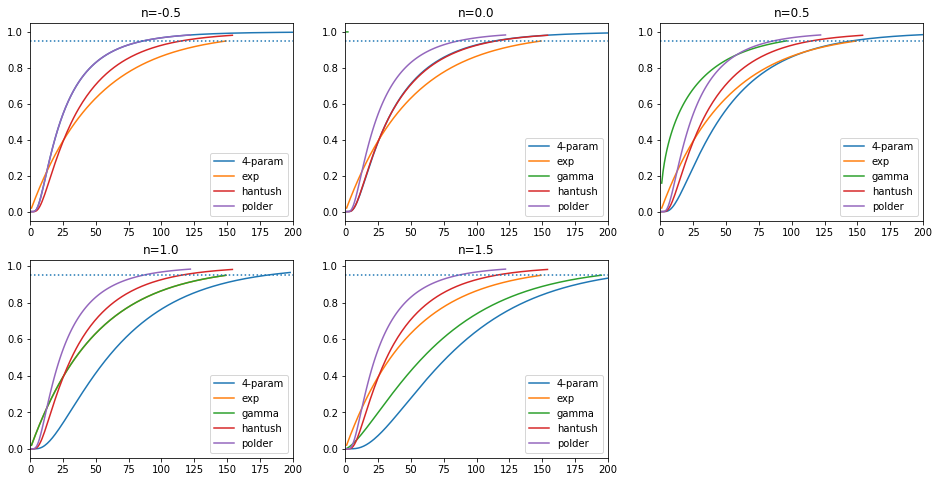

In [9]:
A = 1
a = 50
b = 0.4
plt.figure(figsize=(16, 8))
for i, n in enumerate([-0.5, 1e-6, 0.5, 1, 1.5]):
    plt.subplot(2, 3, i + 1)
    plt.title(f'n={n:0.1f}')
    fp = fourp.step([A, n, a, b], dt=1, cutoff=0.95)
    plt.plot(np.arange(1, len(fp) + 1), fp, 'C0', label='4-param')
    e = exp.step([A, a], dt=1, cutoff=0.95)
    plt.plot(np.arange(1, len(e) + 1), e, 'C1', label='exp')
    if n > 0:
        g = gamma.step([A, n, a], dt=1, cutoff=0.95)
        plt.plot(np.arange(1, len(g) + 1), g, 'C2', label='gamma')
    h = hantush.step([A, a, b], dt=1, cutoff=0.95) / hantush.gain([A, a, b])
    plt.plot(np.arange(1, len(h) + 1), h, 'C3', label='hantush')
    p = polder.step([A, a, b], dt=1, cutoff=0.95) / polder.gain([A, a, b])
    plt.plot(np.arange(1, len(p) + 1), p, 'C4', label='polder')
    plt.xlim(0, 200)
    plt.legend()
    if n > 0:
        print('fp, e, g, h, p:', fp[-1], e[-1], g[-1], h[-1], p[-1])
    else:
        print('fp, e, h, p:', fp[-1], e[-1], h[-1], p[-1])
    plt.axhline(0.95, linestyle=':')

## Parameter settings
- **up** : This parameters determines whether the influence of the stress goes up or down, hence a positive or a negative response function. For example, when groundwater pumping is defined as a positive flux, `up=False` because we want the groundwater levels to decrease as a result of pumping.
- **meanstress** : This parameter is used to estimate the initial value of the stationary effect of a stress. Hence the effect when a stress stays at an unit level for infinite amount of time. This parameter is usually referred from the stress time series and does not have to be provided by the user.
- **cutoff** : This parameter determines for how many time steps the response is calculated. This reduces calculation times as it reduces the length of the array the stress is convolved with. The default value is 0.999, meaning that the response is cutoff after 99.9% of the effect of the stress impulse has occurred. A minimum of length of three times the simulation time step is applied. 

The default parameter values for each of the response function are as follows:

In [10]:
parameters

,initial,pmin,pmax,vary,name
Exponential_A,1.0,0.00001,100.0,True,Exponential
Exponential_a,10.0,0.01,1000.0,True,Exponential
Gamma_A,1.0,0.00001,100.0,True,Gamma
Gamma_n,1.0,0.1,100.0,True,Gamma
Gamma_a,10.0,0.01,10000.0,True,Gamma
Hantush_A,1.0,0,NaN,True,Hantush
Hantush_a,100.0,0.001,10000.0,True,Hantush
Hantush_b,1.0,0.000001,25.0,True,Hantush
Polder_A,1,0,2,True,Polder
Polder_a,10,0.01,1000,True,Polder


## Comparison to classical analytical response functions

### Polder step function compared to classic polder function
The classic polder function is (Eq. 123.32 in Bruggeman, 1999)
$$
h(t) = \Delta h \text{P}\left(\frac{x}{2\lambda}, \sqrt{\frac{t}{cS}}\right)
$$
where P is the polder function.

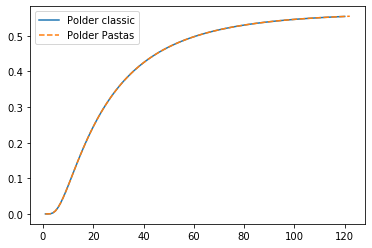

In [21]:
from scipy.special import erfc

def polder_classic(t, x, T, S, c):
    X = x / (2 * np.sqrt(T * c))
    Y = np.sqrt(t / (c * S))
    rv = 0.5 * np.exp(2 * X) * erfc(X / Y + Y) + \
         0.5 * np.exp(-2 * X) * erfc(X / Y - Y)
    return rv

delh = 2
T = 20
c = 5000
S = 0.01
x = 400
x / np.sqrt(c * T)
t = np.arange(1, 121)
h_polder_classic = np.zeros(len(t))
for i in range(len(t)):
    h_polder_classic[i] = delh * polder_classic(t[i], x=x, T=T, S=S, c=c)
#
A = delh
a = c * S
b = x ** 2 / (4 * T * c)
pd = polder.step([A, a, b], dt=1, cutoff=0.95) 
#
plt.plot(t, h_polder_classic, label='Polder classic')
plt.plot(np.arange(1, len(pd) + 1), pd, label='Polder Pastas', linestyle="--")
plt.legend()

### Hantush step function compared to classic Hantush function
The classic Hantush function is 
$$
h(r, t) = \frac{-Q}{4\pi T}\int_u  ^\infty  \exp\left(-y - \frac{r^2}{4  \lambda^2 y} \right) \frac{\text{d}y}{y} 
$$
where
$$
u=\frac{r^2 S}{4 T t}
$$
The parameters in Pastas are
$$
A = \frac{1}{4\pi T}
$$
$$
a = cS
$$
$$
b = \frac{r^2}{4\lambda^2}
$$
where $\lambda^2=cT$.

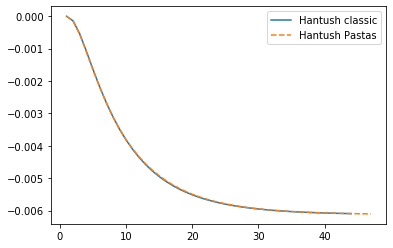

In [23]:
from scipy.integrate import quad

def integrand_hantush(y, r, lab):
    return np.exp(-y - r ** 2 / (4 * lab ** 2 * y)) / y

def hantush_classic(t=1, r=1, Q=1, T=100, S=1e-4, c=1000):
    lab = np.sqrt(T * c)
    u = r ** 2 * S / (4 * T * t)
    F = quad(integrand_hantush, u, np.inf, args=(r, lab))[0]
    return -Q / (4 * np.pi * T) * F

c = 1000 # d
S = 0.01 # -
T = 100 # m^2/d
r = 500 # m
Q = 20 # m^3/d
#
t = np.arange(1, 45)
h_hantush_classic = np.zeros(len(t))
for i in range(len(t)):
    h_hantush_classic[i] = hantush_classic(t[i], r=r, Q=20, T=T, S=S, c=c)
#
a = c * S
b = r ** 2 / (4 * T * c)
ht = hantush.step([1, a, b], dt=1, cutoff=0.99) * (-Q / (2 * np.pi * T))
#
plt.plot(t, h_hantush_classic, label='Hantush classic')
plt.plot(np.arange(1, len(ht) + 1), ht, '--', label='Hantush Pastas')
plt.legend();